In [77]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tqdm
import numpy as np
from PIL import Image
import time
%matplotlib inline

In [1]:
BSTLD_record_path = './record_files/valid.tfrecords'
Udacity_record_path = './record_files/extra_valid.record'
frozen_inference_graph = './frozen_models/SSD_MobileNetV2.pb'
optimized_inference_graph = './frozen_models/optimized/optimized_SSD_MobileNetV2.pb'

In [68]:
def load_model(model_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        graph_def = tf.GraphDef()
        with tf.gfile.GFile(model_path,'rb') as fid:
            serialized_graph = fid.read()
            graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(graph_def,name='')
    return detection_graph

In [43]:
def imgs_labels_tfrecord(tf_record):
    labels = []
    images = []
    with tf.Session() as sess:
        for record in tqdm.tqdm(tf.python_io.tf_record_iterator(tf_record),desc=None):
            example = tf.train.Example()
            example.ParseFromString(record)
            label = {
                'class_labels': [
                    class_id-1 for class_id in
                    example.features.feature['image/object/class/label'].int64_list.value
                ]
            }
            labels.append(label)
            image = example.features.feature['image/encoded'].bytes_list.value[0]
            image = tf.image.decode_png(image,channels=3).eval()
            images.append(np.expand_dims(image,0))
    return images, labels

In [5]:
def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        # Find first detection of traffic signal,which is labeled with number 10
        if scores[i] >= min_score:
            idxs.append(i)

    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes


In [6]:
images,labels = imgs_labels_tfrecord(BSTLD_record_path)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


517it [02:14,  2.28it/s]


In [44]:
ud_image,ud_label = imgs_labels_tfrecord(Udacity_record_path)

459it [09:33,  1.24s/it]


In [61]:
def detection(frozen_graph,tf_record,images,labels):
    detection_graph = load_model(frozen_graph)
    config = tf.ConfigProto(log_device_placement=True)
    tf_session= tf.Session(graph=detection_graph,config=config)
    #Input place holder for images
    #get_tensor_by_name returns the Tensor with the associated name
    image_tensor= detection_graph.get_tensor_by_name('image_tensor:0')
    #Box represents particular object in the image, in our case Traffic light
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    #Detection Score represents level of confidence for detecing  object
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    #Detection class represents classification of the object
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    #Number of detections
    num_detection = detection_graph.get_tensor_by_name('num_detections:0')
    positive = 0
    negative = 0
    for i,image in enumerate(images):
        with detection_graph.as_default():
            (boxes,scores,classes,num) = tf_session.run([detection_boxes,detection_scores,detection_classes,
                                                        num_detection],feed_dict={image_tensor:image})
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes).astype(np.int32)

        detection_threshold = 0.5
        boxes, scores, classes = filter_boxes(detection_threshold,boxes,scores,classes)
        if not classes.any():
            continue
        if classes[0] == 4:
            continue
        if labels[i]['class_labels'] == None:
            continue
        if classes[0] == labels[i]['class_labels'][0]+1:
            positive +=1
        elif len(labels[i]['class_labels'])>1:
            if classes[0] == labels[i]['class_labels'][1]+1:
                positive +=1
        else:
            negative +=1
    return positive/(positive+negative)


### Accuracy of inference graph

Accuracy on BSTLD dataset
(Only checks whether light detected was actually on the data. Accuracy of location of boxes, or whether model was able to find all the possible labels were not calculated)

99.2% accuracy

In [62]:
print(detection(frozen_inference_graph,BSTLD_record_path,images,labels))

0.992


Accuracy on Udacity dataset
(All the detection was able to label all possible detection on data. This is due to clarity of dataset: data only included one traffic light or one set of traffic lights per image) 

100% accuracy


In [63]:
print(detection(frozen_inference_graph,Udacity_record_path,ud_image,ud_label))

1.0


### Accuracy of Optimized inference graph

In [134]:
print(detection(optimized_inference_graph,BSTLD_record_path,images,labels))

0.992


In [135]:
print(detection(optimized_inference_graph,Udacity_record_path,ud_image,ud_label))

1.0


# Detection Time

In [91]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [129]:
def detection_timing(graph_path):
    detection_graph = load_model(frozen_inference_graph)
    with tf.Session(graph=detection_graph) as sess:
        times = time_detection(sess, 600, 1000, runs=1000)
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    plt.title("Object Detection Timings")
    plt.ylabel("Time (ms)")

    # Create the boxplot
    plt.style.use('fivethirtyeight')
    bp = ax.boxplot(times)
    mean = np.average(times)
    meanString = '%.2f' % mean
    print("Average detction timing is: "+meanString)

### Detection timing of inference graph

Average detction timing is: 22.86


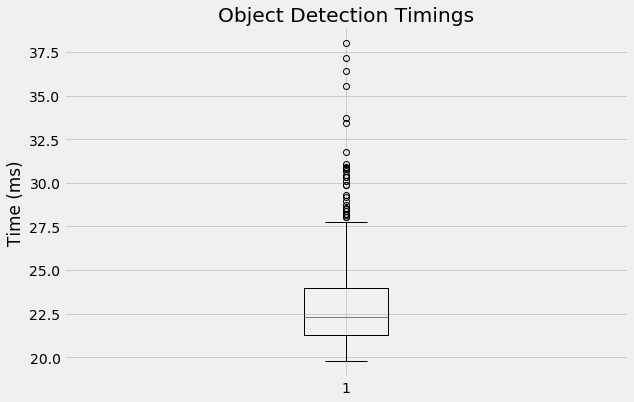

In [144]:
detection_timing(frozen_inference_graph)

### Detection timing of optimized inference graph

Average detction timing is: 22.91


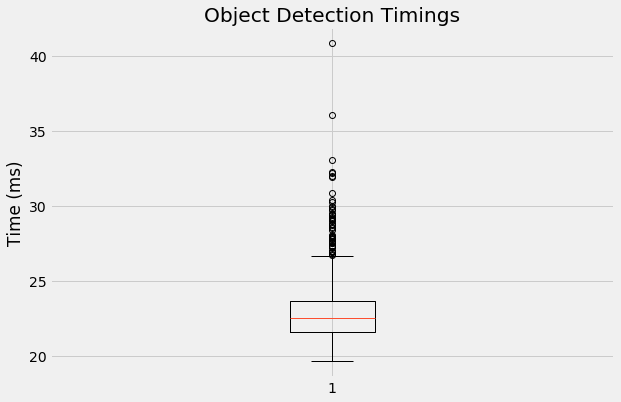

In [145]:
detection_timing(optimized_inference_graph)